In [1]:
import tensorflow as tf
from tensorflow import keras
import pylab as pl
import pandas as pd
import cv2 # computer vision tool --> per la visualizzazione delle immagini
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/MLPNS/

/content/drive/MyDrive/MLPNS


In [ ]:
import json
import os
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [ ]:
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

all_zeros_benchmark.zip: Skipping, found more recently modified local copy (use --force to force download)
images_training_rev1.zip: Skipping, found more recently modified local copy (use --force to force download)
images_test_rev1.zip: Skipping, found more recently modified local copy (use --force to force download)
central_pixel_benchmark.zip: Skipping, found more recently modified local copy (use --force to force download)
training_solutions_rev1.zip: Skipping, found more recently modified local copy (use --force to force download)
all_ones_benchmark.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip images_training_rev1.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: images_training_rev1/926425.jpg  
  inflating: images_training_rev1/926426.jpg  
  inflating: images_training_rev1/926435.jpg  
  inflating: images_training_rev1/926446.jpg  
  inflating: images_training_rev1/926448.jpg  
  inflating: images_training_rev1/926453.jpg  
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflatin

In [ ]:
!unzip training_solutions_rev1.zip

In [ ]:
!ls

all_ones_benchmark.zip	     images_training_rev1.zip
all_zeros_benchmark.zip      kaggle.json
central_pixel_benchmark.zip  logs
country_pop.xls		     spm
galimgs.npy		     spm-20210427T111354Z-001.zip
images_test_rev1.zip	     training_solutions_rev1.csv
images_training_rev1	     training_solutions_rev1.zip


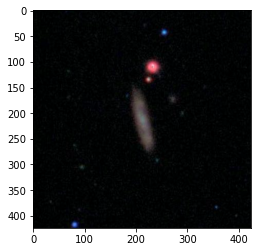

In [ ]:
# esempio di una delle immagini
img = np.asarray(cv2.imread("images_training_rev1/313205.jpg"))
pl.imshow(img);

In [ ]:
# si leggono le prime mille immagini come array
import glob # per leggere le immagini una dopo l'altra
ims = np.zeros([1000, img.shape[0], img.shape[1], img.shape[2]], dtype=np.uint8) # contenitore per l'immagine
for i,im in enumerate(glob.glob("images_training_rev1/*")[:1000]):
  if i%10 == 0:
    print ("index", i, end="\r", flush=True)
  ims[i] = np.asarray( cv2.imread(im))

In [ ]:
np.save('galimgs.npy', ims) # --> si salvano per poterle riaprire da un file
# le immagini in galims sono già salvate con 1 pixel ogni 2

In [4]:
# per riaprire le immagini dal file
ims = np.load("galimgs.npy")

In [ ]:
ims.shape # dati da passare alla rete neurale

(1000, 424, 424, 3)

In [5]:
ims.max(), ims.min()

(255, 0)

In [6]:
ims = ims / 255 # normalizzazione

In [7]:
training_labels = pd.read_csv("training_solutions_rev1.csv")

In [8]:
training_labels # classificazione probabilistica in 18 classi

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.000000,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.00000,0.027226,0.000000,0.027226,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.000000,0.000000,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.000000,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.00000,0.000000,0.140353,0.000000,0.048796,0.000000,0.000000,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.000000,0.000000,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.000000,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.000000,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.00000,0.000000,0.096119,0.096119,0.000000,0.128159,0.000000,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.000000,0.000000,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.029383,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61573,999948,0.510379,0.489621,0.000000,0.059207,0.430414,0.000000,0.430414,0.226257,0.204157,0.043458,0.260804,0.000000,0.126152,0.245734,0.754266,0.000000,0.410816,0.099563,0.03514,0.000000,0.000000,0.000000,0.175454,0.035140,0.000000,0.059207,0.0,0.000000,0.226257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.226257
61574,999950,0.901216,0.098784,0.000000,0.000000,0.098784,0.000000,0.098784,0.000000,0.098784,0.000000,0.045378,0.053406,0.000000,0.127644,0.872356,0.404841,0.496375,0.000000,0.00000,0.000000,0.021321,0.000000,0.062095,0.044229,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
61575,999958,0.202841,0.777376,0.019783,0.116962,0.660414,0.067245,0.593168,0.140022,0.520391,0.000000,0.257128,0.347328,0.055958,0.839186,0.160814,0.030477,0.172364,0.000000,0.00000,0.000000,0.033567,0.134270,0.067135,0.604214,0.000000,0.116962,0.0,0.000000,0.000000,0.090673,0.049349,0.000000,0.067726,0.000000,0.000000,0.0,0.072296
61576,999964,0.091000,0.909000,0.000000,0.045450,0.863550,0.022452,0.841098,0.795330,0.068220,0.000000,0.227114,0.545764,0.090673,0.864000,0.136000,0.045500,0.045500,0.000000,0.09072,0.000000,0.090720,0.136512,0.045792,0.500256,0.000000,0.045450,0.0,0.000000,0.068398,0.318132,0.408799,0.227464,0.408799,0.090668,0.023065,0.0,0.045334


In [9]:
# si riduce a 4 classi probabilistiche su cui creare un classificatore
# valore tra 0 e 3 associato a ciascuna classe 
nga = training_labels["Class1.3"] # probabilità che non sia una galassia
spi = training_labels[["Class5.1", "Class5.2", "Class5.3", "Class5.4"]].max(axis=1) # probabilità per galassia a spirale
ell = training_labels["Class6.2"] # galassia ellittica
irr = training_labels[["Class8.1", "Class8.2", "Class8.3", "Class8.4", "Class8.5", "Class8.6", "Class8.7"]].max(axis=1)
# sono dataframe

In [10]:
# si attibuisce un valore tra 0 e 3 in base alla galassia con la probabilità maggiore
# where: indice dove è valida l'affermazione
training_labels2 = pd.DataFrame({"nga": nga, "spi":spi, "ell":ell, "irr":irr})
newclass = [np.where(training_labels2.iloc[i] == np.max(training_labels2.iloc[i]))[0][0] 
            for i in range(len(training_labels2))]
# si identifica una classe (da 0 a 3) per ogni immagine e non una probabilità di appartenenza a ogni classe

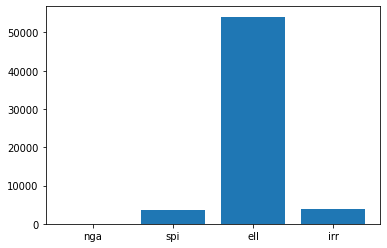

In [28]:
n = []
cl = ['nga', 'spi', 'ell', 'irr']
for i,c in enumerate(cl):
  n.append(np.sum(newclass == i*np.ones(len(newclass))))
pl.bar(cl, n);

sono quasi tutte ellittiche (unbalanced) --> può essere un problema

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ims, np.array(newclass[:1000]), test_size=0.33, random_state=42) # ims[:,::2,::2,:]
# un pixel ogni 2 per non esaurire la memoria

In [30]:
batch_size = 128
num_classes = 4
epochs = 50
input_shape = (212, 212, 3) # ims[0].shape

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [32]:
from keras.optimizers import Adam

# Set Optimizer
opt = Adam(lr=0.001, decay=1e-6)

In [53]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(10,10), activation="relu", input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(l=0.001), padding="same"))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, kernel_size=(10,10), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.001), padding="same"))
model.add(Dropout(0.5))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, kernel_size=(10,10), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.001), padding="same"))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(4, activation="softmax", kernel_regularizer=keras.regularizers.l2(l=0.001)))
# convolutional per riconoscimento immagini
# relu come activation per i conv2D generalmente va bene
# dim della forma da cercare nell'img 240x240
# 32 neuroni per il primo layer
# 10x10 kernel
# alternare conv2D e maxpool
# maxpool: aggrega gruppi di pixel e rimpiazza col max
# sopprime il rumore e riduce la dimensionalità delle shape imparate col convolutional layer
# altri layer: dropout --> rimuovono neuroni a caso e si riduce la possibilità di overtraining
# ultimi 2 layer: flatten e dense per raccogliere tutte le info
# dim finale 4
# quale loss --> categorical cross entropy per multiclass

In [54]:
model.compile(opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

*categorical_crossentropy*

Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a one_hot representation. If you want to provide labels as integers, please use SparseCategoricalCrossentropy loss. There should be # classes floating point values per feature.

In [55]:
# from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(x_train, y_train, epochs=epochs,
                    validation_split=0.2,
                    batch_size=batch_size, verbose=1)
                    #callbacks=es)

Epoch 1/50
5/5 [==============================] - 11s 781ms/step - loss: 2.0663 - accuracy: 0.5320 - val_loss: 0.6960 - val_accuracy: 0.8433
Epoch 2/50
5/5 [==============================] - 1s 265ms/step - loss: 0.8029 - accuracy: 0.8904 - val_loss: 0.6883 - val_accuracy: 0.8433
Epoch 3/50
5/5 [==============================] - 1s 263ms/step - loss: 0.6000 - accuracy: 0.8924 - val_loss: 0.7760 - val_accuracy: 0.8433
Epoch 4/50
5/5 [==============================] - 1s 261ms/step - loss: 0.5741 - accuracy: 0.8923 - val_loss: 0.7143 - val_accuracy: 0.8433
Epoch 5/50
5/5 [==============================] - 1s 266ms/step - loss: 0.5947 - accuracy: 0.8839 - val_loss: 0.7259 - val_accuracy: 0.8433
Epoch 6/50
5/5 [==============================] - 1s 266ms/step - loss: 0.5763 - accuracy: 0.8818 - val_loss: 0.7091 - val_accuracy: 0.8433
Epoch 7/50
5/5 [==============================] - 1s 260ms/step - loss: 0.6017 - accuracy: 0.8775 - val_loss: 0.7061 - val_accuracy: 0.8433
Epoch 8/50
5/5 [===

In [56]:
loss_tr, acc_tr = model.evaluate(x_train, y_train)
loss_te, acc_te = model.evaluate(x_test, y_test)
print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

11/11 [==============================] - 1s 68ms/step - loss: 0.4200 - accuracy: 0.9152
Training accuracy : 0.8791
Testing accuracy  : 0.9152


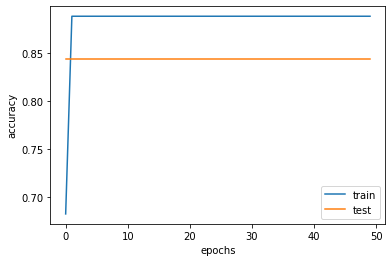

In [57]:
pl.plot(history.history['accuracy'], label='train') # logscale se l'incremento iniziale è rapido
pl.plot(history.history['val_accuracy'], label='test')
pl.xlabel('epochs')
pl.ylabel('accuracy')
pl.legend()

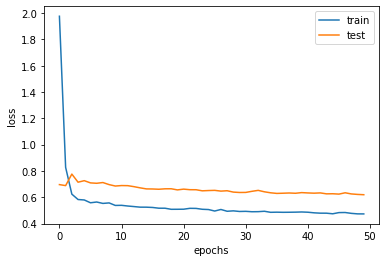

In [58]:
pl.plot(history.history['loss'], label='train')
pl.plot(history.history['val_loss'], label='test')
pl.xlabel('epochs')
pl.ylabel('loss')
pl.legend()